<a href="https://colab.research.google.com/github/jcamachoc-oss/Tarea-4-IA-y-Mini-Robots/blob/main/Punto_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	min    	avg    
0  	150   	27.1266	167.248
1  	93    	27.1266	153.243
2  	84    	27.1266	123.225
3  	100   	26.7583	90.614 
4  	110   	26.3828	68.0034
5  	90    	26.3828	61.8309
6  	101   	26.3828	65.2359
7  	102   	26.3828	63.0302
8  	108   	26.3396	61.5083
9  	105   	26.28  	71.7479
10 	98    	25.6071	57.5556
11 	93    	25.6071	45.7583
12 	88    	25.4635	46.5297
13 	103   	25.4295	51.7752
14 	97    	25.3263	49.6266
15 	107   	25.3263	43.6056
16 	96    	24.9872	46.6125
17 	103   	24.9872	44.98  
18 	88    	25.0105	38.2786
19 	106   	25.164 	42.243 
20 	97    	24.9365	41.3694
21 	91    	24.9365	40.4446
22 	95    	24.9998	43.173 
23 	96    	24.8904	31.1252
24 	94    	24.9685	40.5782
25 	104   	24.9333	40.6149
26 	114   	24.9397	40.4918
27 	112   	24.9397	43.8651
28 	90    	24.9058	38.5417
29 	85    	24.8877	35.3649
30 	95    	24.8785	42.2908
31 	89    	24.8734	37.2259
32 	95    	24.8719	41.227 
33 	99    	24.8719	39.1453
34 	106   	24.8772	44.3502
35 	85    	24.8693	31.3654
3

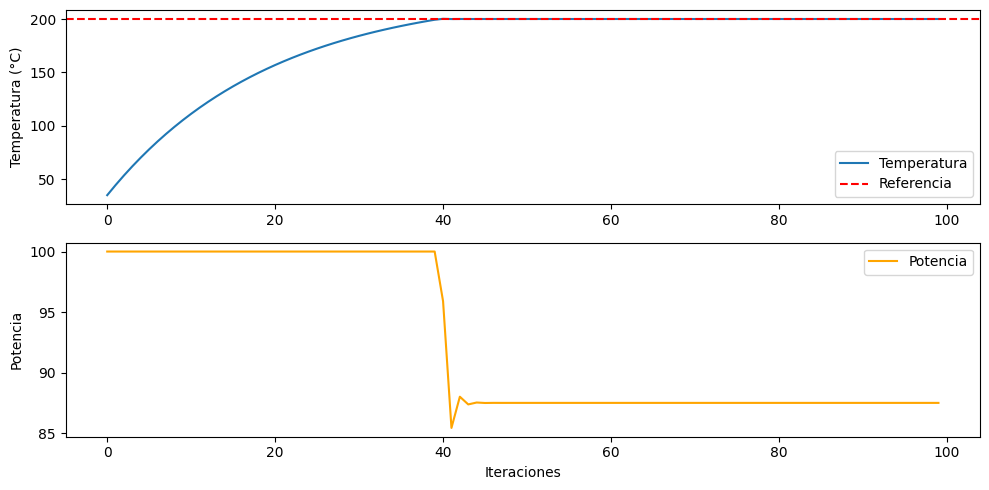

In [3]:
!pip install deap --quiet
import operator
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, gp, algorithms


T_amb = 25.0                 # Temperatura ambiente [°C]
ganancia_calentador = 0.1    # Ganancia del calentador
coef_perdida = 0.05          # Coeficiente de pérdida
T_ref = 200.0                # Temperatura deseada
pasos_simulacion = 100       # Duración de la simulación



def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1.0


pset = gp.PrimitiveSet("MAIN", 4)  # 4 entradas: error, error_prev, P_prev, T
pset.renameArguments(ARG0='error')
pset.renameArguments(ARG1='error_prev')
pset.renameArguments(ARG2='P_prev')
pset.renameArguments(ARG3='T')

# Operadores matemáticos
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(math.sin, 1)
pset.addPrimitive(math.tanh, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(operator.neg, 1)

# Constantes fijas
pset.addTerminal(1.0)
pset.addTerminal(0.1)

# Constantes aleatorias (simulan Kp, Ki, etc.)
for _ in range(10):
    pset.addTerminal(random.uniform(0.01, 2.0))



def simular_controlador(individuo):
    func = toolbox.compile(expr=individuo)
    T = 25.0
    error_prev = T_ref - T
    P_prev = 0.0
    error_total = 0.0

    for _ in range(pasos_simulacion):
        error = T_ref - T
        try:
            P = func(error, error_prev, P_prev, T)
        except Exception:
            P = 0.0

        # limitar potencia a [0, 100]
        P = max(0, min(P, 100))

        # dinámica del horno
        T = T + ganancia_calentador * P - coef_perdida * (T - T_amb)

        # acumular error
        error_total += abs(error)

        # actualizar memoria
        error_prev = error
        P_prev = P

    # promedio del error (menor es mejor)
    return (error_total / pasos_simulacion,)

# ==================== CONFIGURAR DEAP ====================
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
toolbox.register("evaluate", simular_controlador)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# ==================== EJECUCIÓN EVOLUTIVA ====================
pop = toolbox.population(n=150)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values[0])
stats.register("min", np.min)
stats.register("avg", np.mean)

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.3, ngen=60,
                               stats=stats, halloffame=hof, verbose=True)

best = hof[0]
print("\n Mejor controlador evolutivo encontrado:")
print(best)
print(f"Aptitud (error promedio): {best.fitness.values[0]:.4f}")

# ==================== SIMULACIÓN FINAL ====================
def respuesta_temporal(individuo):
    func = toolbox.compile(expr=individuo)
    T = 25.0
    error_prev = T_ref - T
    P_prev = 0.0
    temperaturas = []
    potencias = []

    for _ in range(pasos_simulacion):
        error = T_ref - T
        P = func(error, error_prev, P_prev, T)
        P = max(0, min(P, 100))
        T = T + ganancia_calentador * P - coef_perdida * (T - T_amb)
        temperaturas.append(T)
        potencias.append(P)
        error_prev = error
        P_prev = P

    return temperaturas, potencias

# Ejecutar simulación final
temps, pots = respuesta_temporal(best)

# ==================== GRAFICAR RESULTADOS ====================
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(temps, label="Temperatura")
plt.axhline(T_ref, color='r', linestyle='--', label="Referencia")
plt.ylabel("Temperatura (°C)")
plt.legend()
plt.subplot(2,1,2)
plt.plot(pots, color='orange', label="Potencia")
plt.ylabel("Potencia")
plt.xlabel("Iteraciones")
plt.legend()
plt.tight_layout()
plt.show()
